# Setting the task

    The dataset.csv file is located in the same folder on the disk

    Your task is to analyze the data, build and evaluate a classification model. The choice of metrics and models is yours. The solution must be uploaded in the format.epub or .html

    The work will be evaluated according to the following criteria:

    - High-quality EDA
    - Correct and reasonable data transformations
    - Correct and informed training and evaluation of the model
    - Code quality and purity of jupiter notebook


    Description of the data

    This is the HR dataset. The task is to check whether the employee has received a promotion or not.
    Column names:
        •	employee_id
        •	department
        • region
        •	education
        •	gender
        •	recruitment_channel
        •	no of trainings
        •	age
        •	previous year rating
        •	length of service
        •	KPIs_met >80%
        •	awards_won?
        •	avg training score
        •	is_prompted

    If the column name still doesn't make it clear what it contains, we expect you to make your assumptions based on data analysis

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Загрузка данных
df = pd.read_csv('/content/drive/MyDrive/HR_promotions/dataset.csv')

# EDA

In [5]:
display(df.info())
display(df.describe())
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


None

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

    We can see none in previous_year_rating 4124, education 2409
    In no_of_trainings almost all values = 1
    I can guess that length_of_service is a duration of work in that company
    categorical_features:
        department
        region
        education
        gender
        recruitment_channel
        KPIs_met >80%
        awards_won?
    
    numerical_features:
        no_of_trainings
        age
        previous_year_rating
        length_of_service
        avg_training_score
        
    target:
        is_promoted # a huge disbalance 8.5% - 1

In [6]:
numerical_features = [
    'no_of_trainings',
    'age',
    'previous_year_rating',
    'length_of_service',
    'avg_training_score',
    ]

In [7]:
categorical_features = [
    'department',
    'region',
    'education',
    'gender',
    'recruitment_channel',
    'KPIs_met >80%',
    'awards_won?',
    ]

In [8]:
target_feature = ['is_promoted']

In [10]:
corr_matrix = df[numerical_features + target_feature].corr()
display(corr_matrix)

,no_of_trainings,age,previous_year_rating,length_of_service,avg_training_score,is_promoted
no_of_trainings,1.000000,-0.081278,-0.063126,-0.057275,0.042517,-0.024896
age,-0.081278,1.000000,0.006008,0.657111,-0.048380,-0.017166
previous_year_rating,-0.063126,0.006008,1.000000,0.000253,0.075139,0.159320
length_of_service,-0.057275,0.657111,0.000253,1.000000,-0.038122,-0.010670
avg_training_score,0.042517,-0.048380,0.075139,-0.038122,1.000000,0.181147
is_promoted,-0.024896,-0.017166,0.159320,-0.010670,0.181147,1.000000


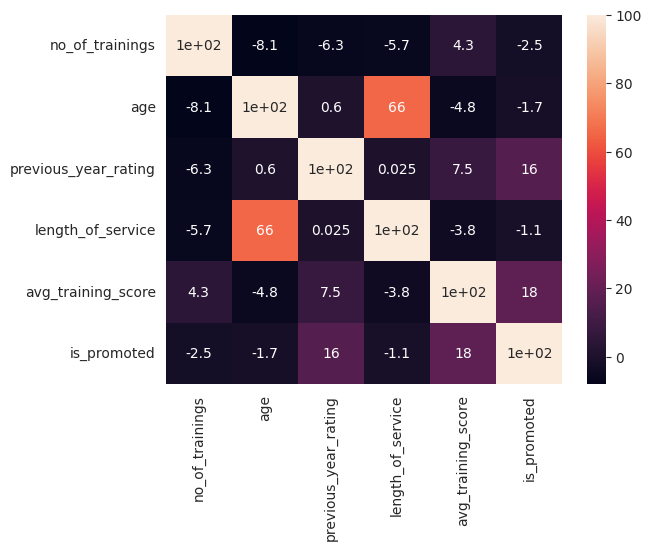

In [37]:
sns.heatmap(corr_matrix*100, annot=True);

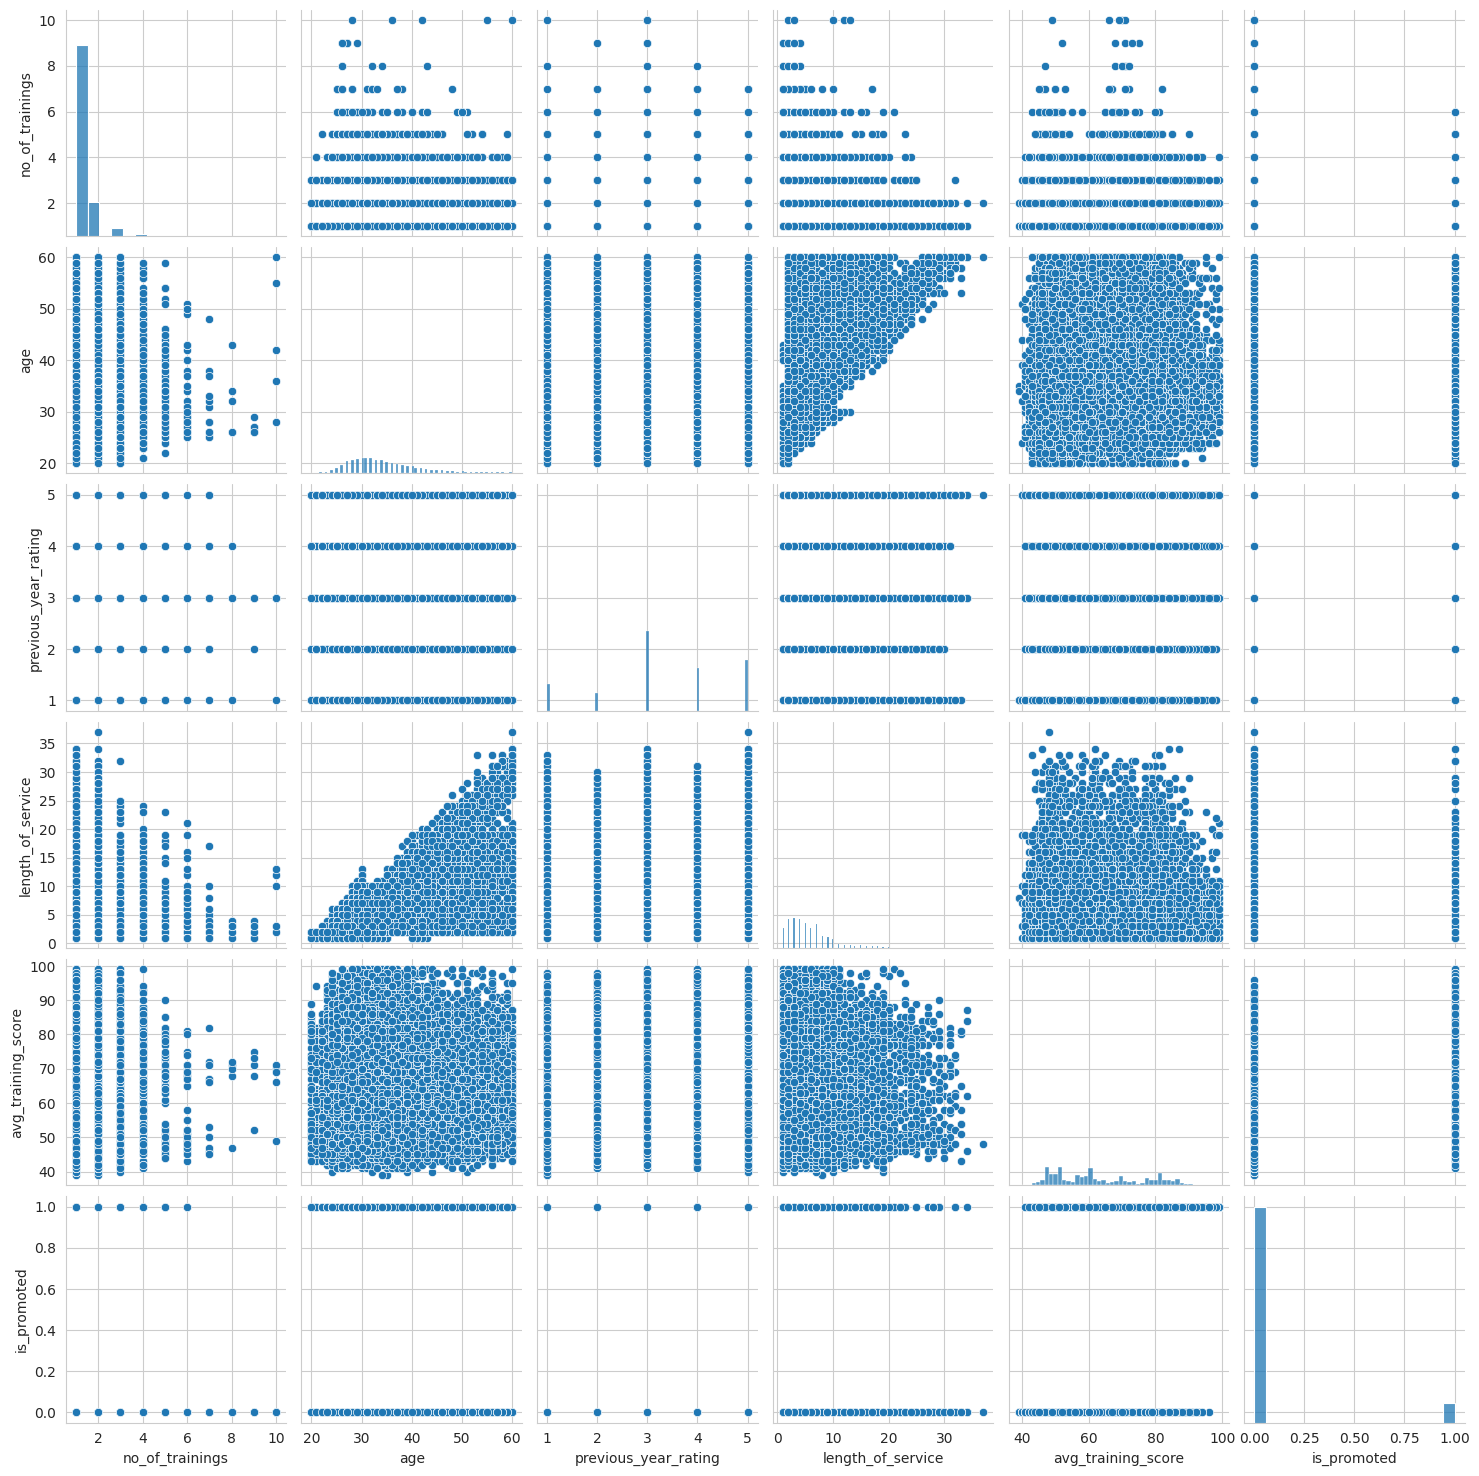

In [38]:
sns.pairplot(df[numerical_features + target_feature])

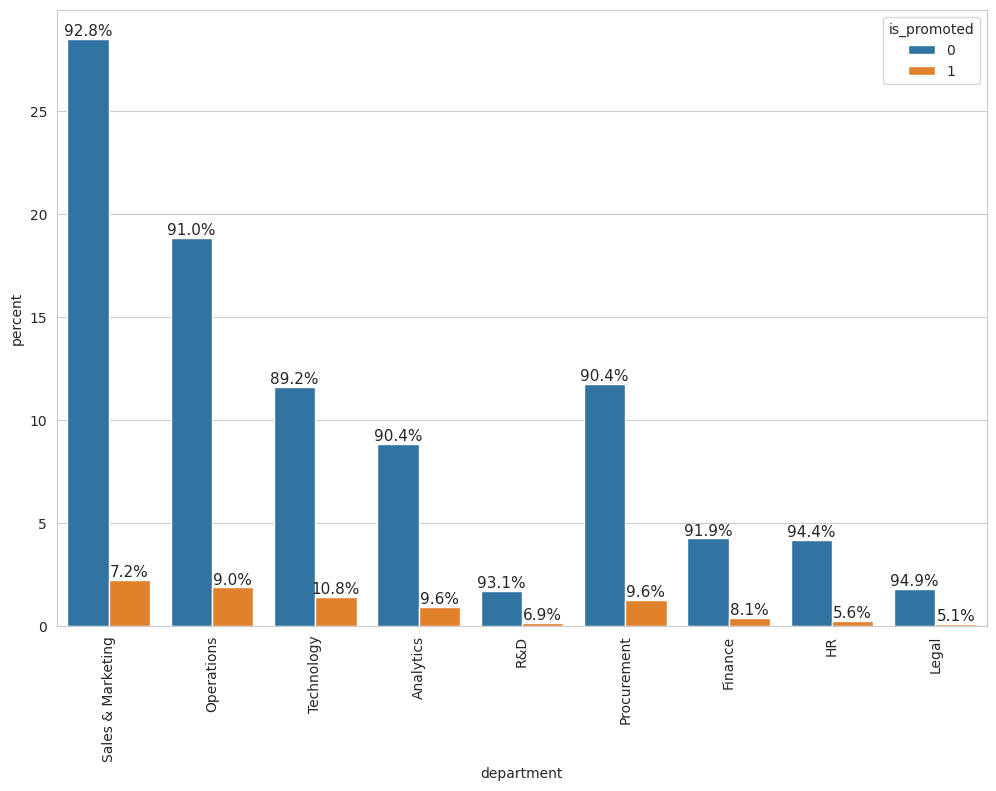

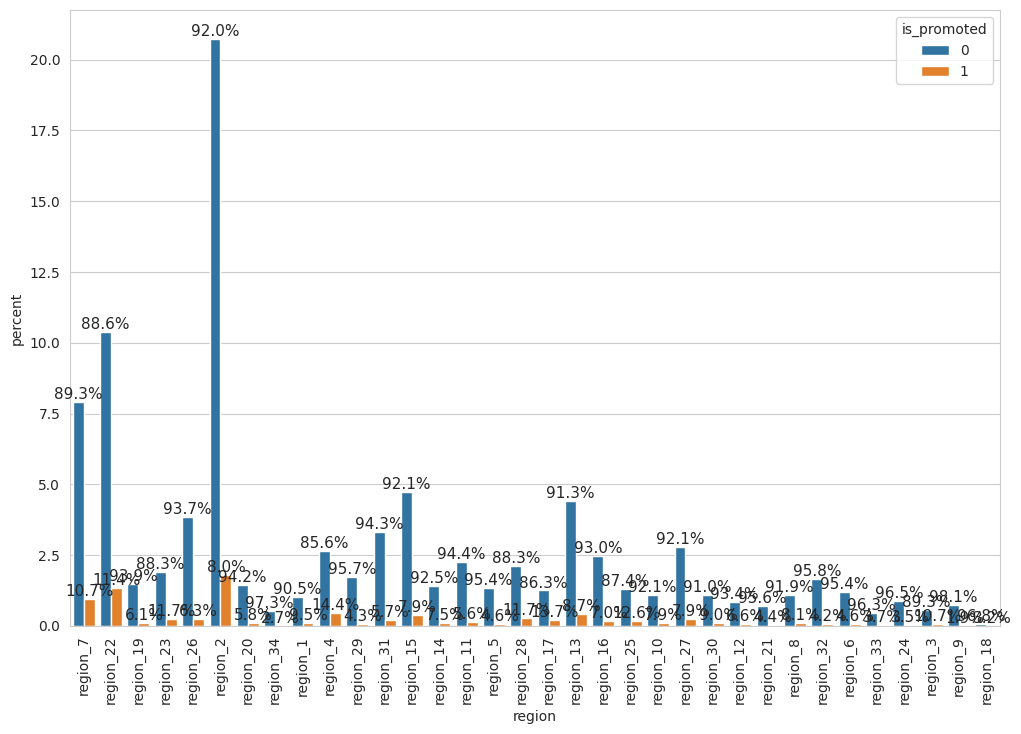

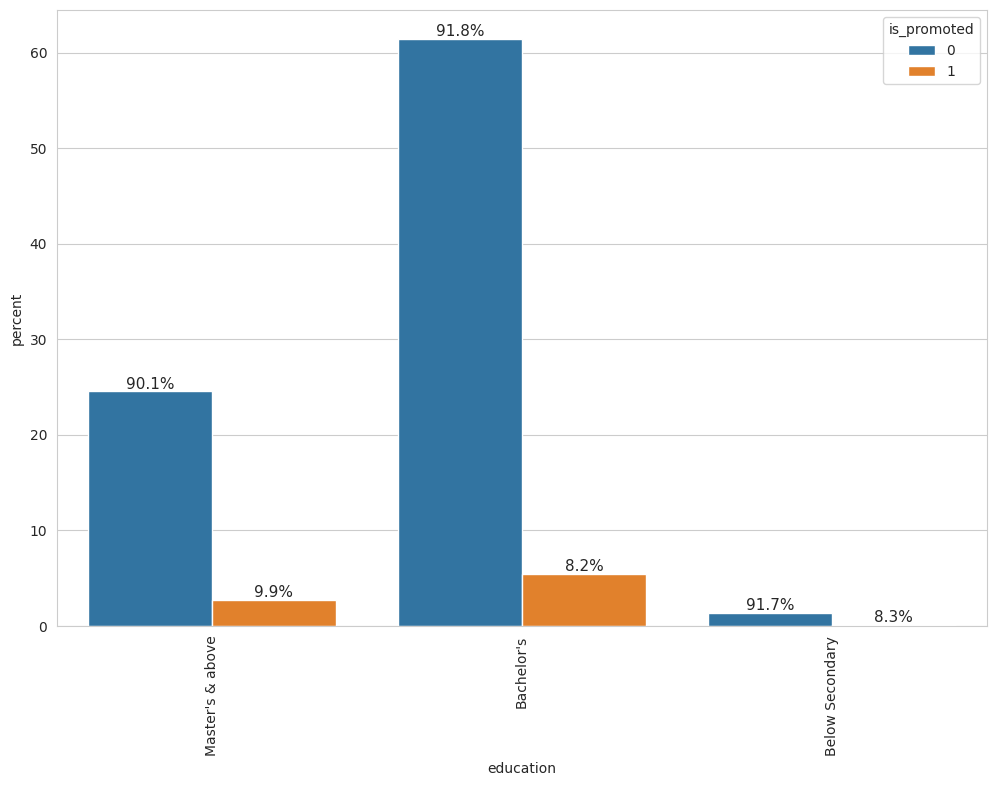

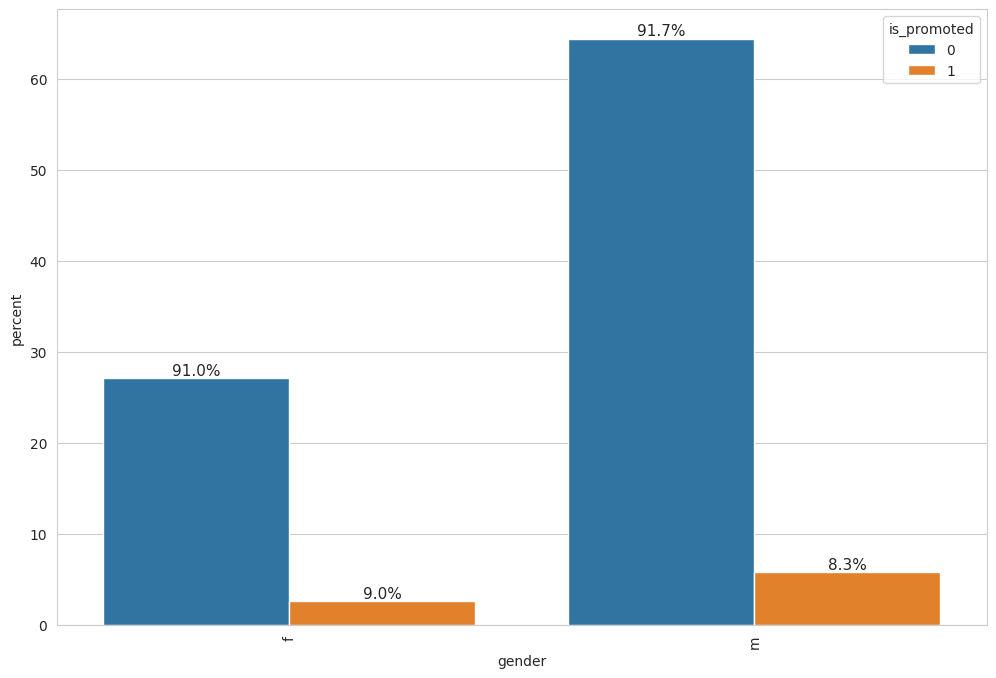

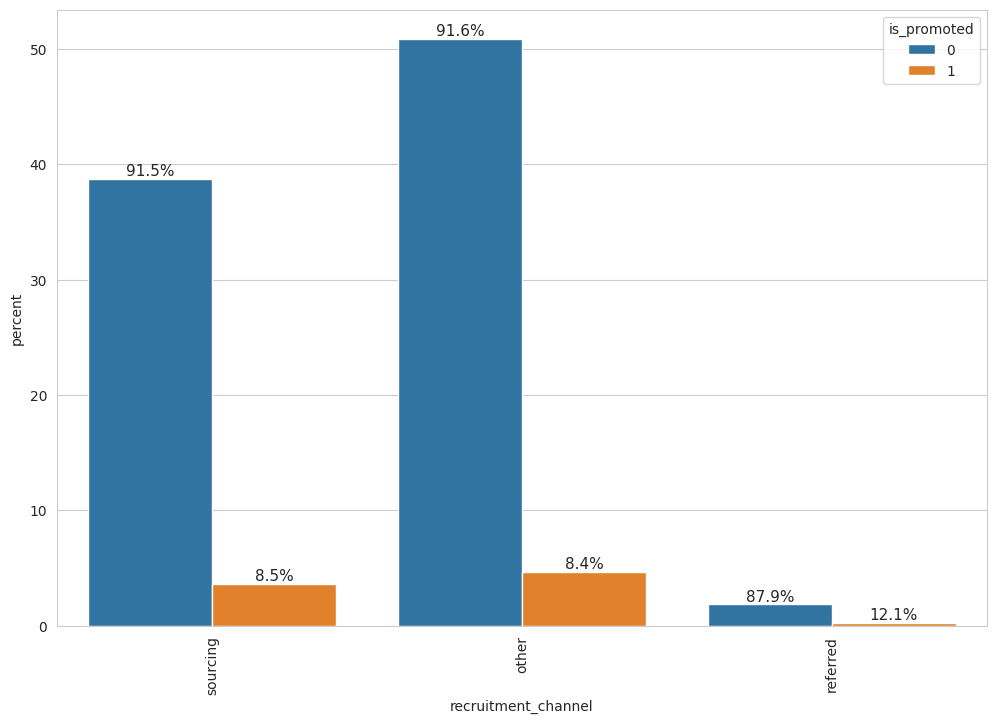

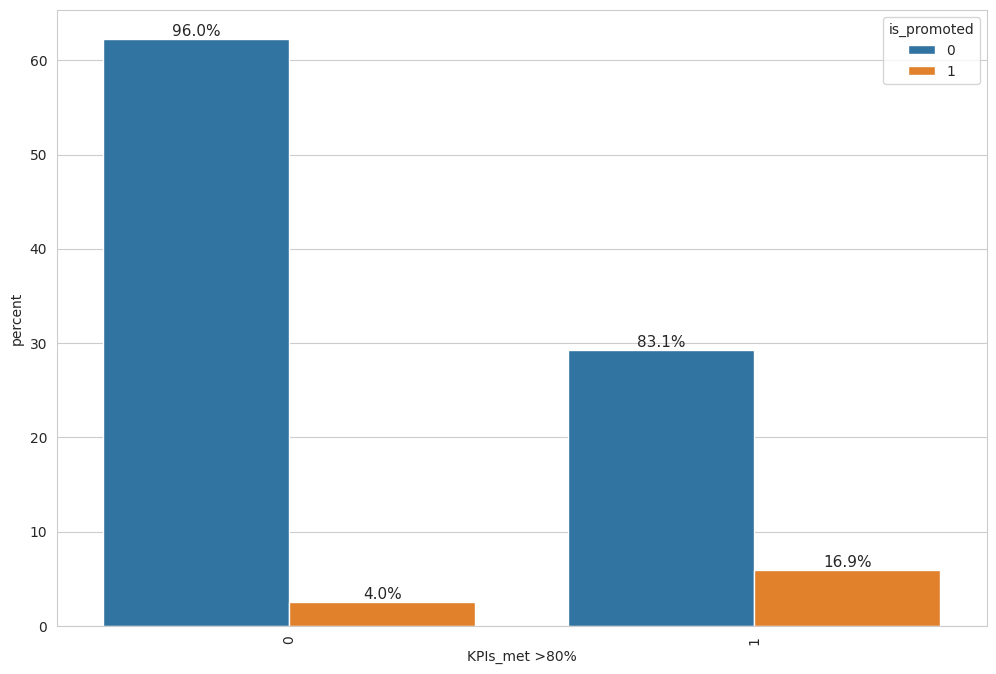

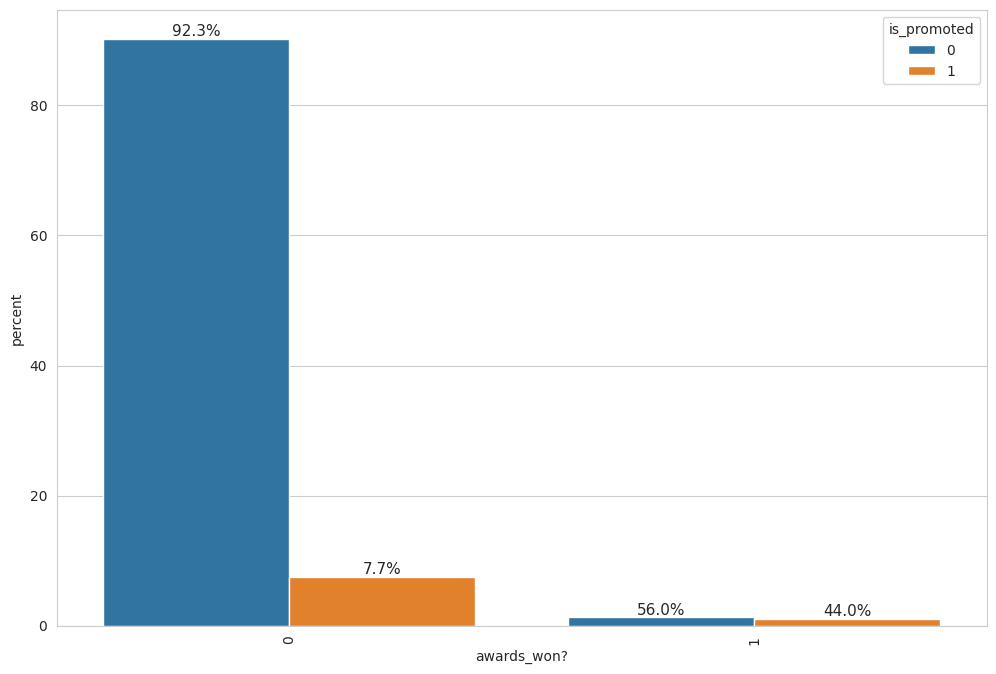

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def percentage_above_bar_relative_to_xgroup(ax):
    all_heights = [[p.get_height() for p in bars] for bars in ax.containers]
    for bars in ax.containers:
        for i, p in enumerate(bars):
            total = sum(xgroup[i] for xgroup in all_heights)
            percentage = f'{(100 * p.get_height() / total) :.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), size=11, ha='center', va='bottom')

for cat in categorical_features:
    plt.figure(figsize=(12, 8))
    ax3 = sns.countplot(x=cat, hue=target_feature[0], data=df, stat="percent")

    percentage_above_bar_relative_to_xgroup(ax3)
    plt.xticks(rotation = 90)
plt.show()

In [83]:
df.groupby('region')[target_feature[0]].agg(['mean', 'count']).reset_index().sort_values('mean')

,region,mean,count
33,region_9,0.019048,420
27,region_34,0.027397,292
9,region_18,0.032258,31
16,region_24,0.035433,508
26,region_33,0.037175,269
25,region_32,0.042328,945
21,region_29,0.043260,994
13,region_21,0.043796,411
29,region_5,0.045692,766
30,region_6,0.046377,690


In [81]:
df.groupby('no_of_trainings')[target_feature[0]].agg(['mean', 'count']).reset_index()

,no_of_trainings,mean,count
0,1,0.088107,44378
1,2,0.075748,7987
2,3,0.068694,1776
3,4,0.055556,468
4,5,0.023438,128
5,6,0.045455,44
6,7,0.000000,12
7,8,0.000000,5
8,9,0.000000,5
9,10,0.000000,5


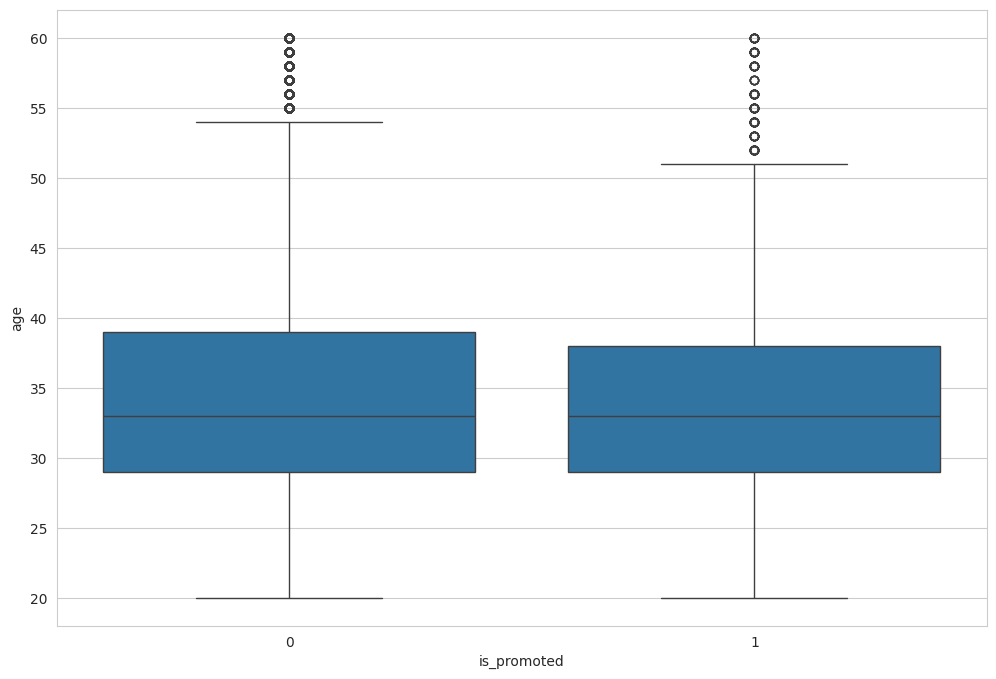

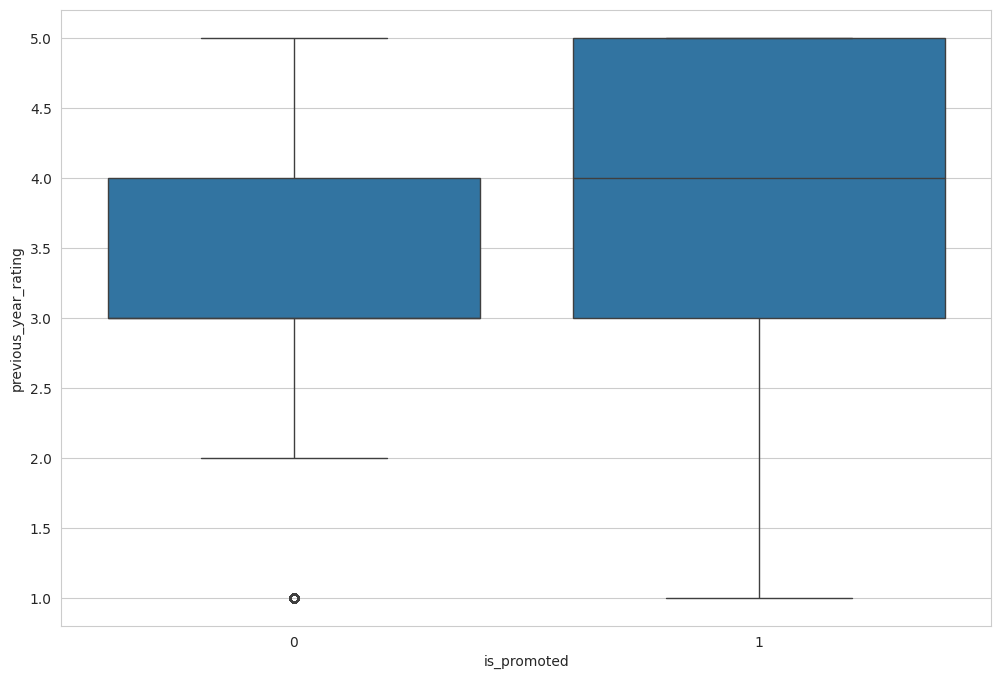

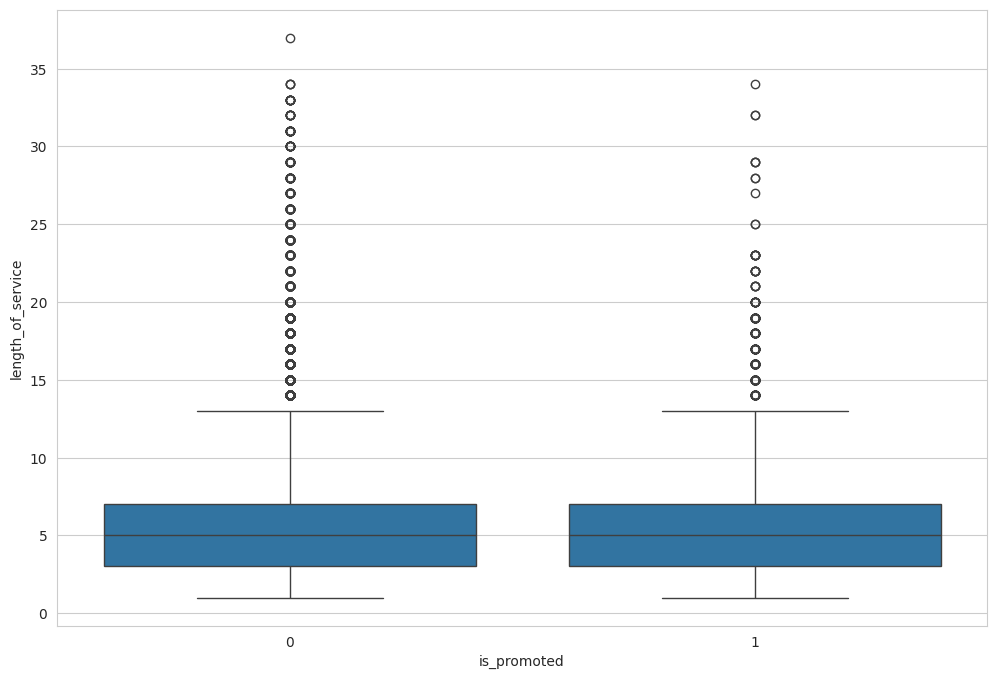

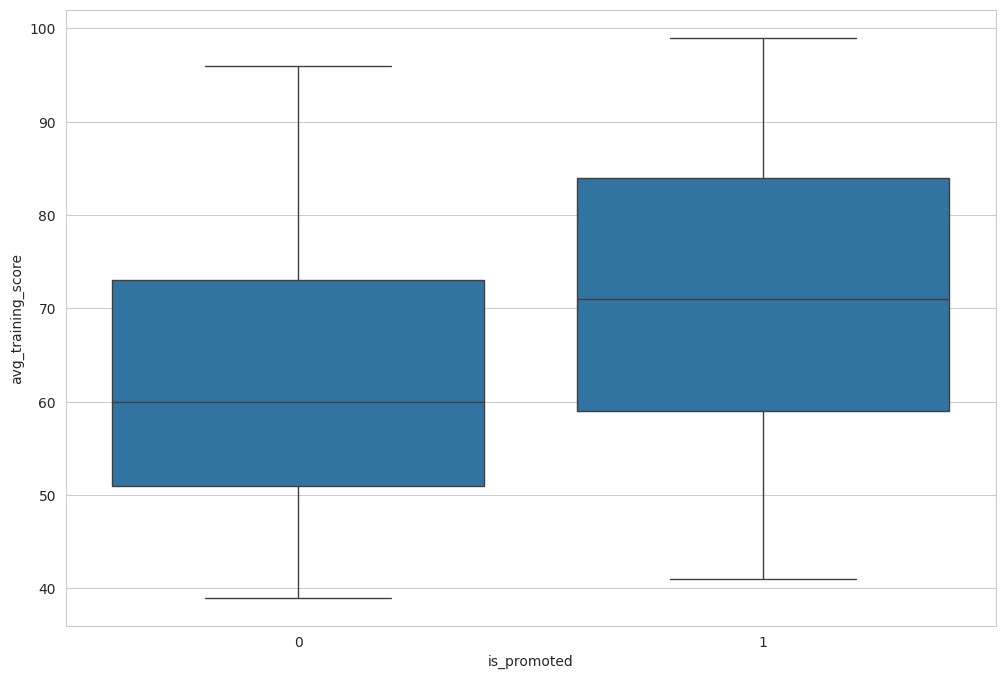

In [82]:
for num in numerical_features[1:]:
    plt.figure(figsize=(12, 8))
    ax = sns.boxplot(x=target_feature[0], y=num, data=df)
plt.show()

# EDA Results
## Correlation and general info
    1. **avg_training_score** - correlation with is_promoted 0.181147
    2. **previous_year_rating**- correlation with is_promoted 0.159320
    3. strong correlation between length_of_service with age 0.657111
    4. avg is_promoted = 8.5 %

## Categorical features
    1. **department** has influence on is_promoted (Technology - 10.8%, Legal - 5.1%)
    2. **region** also has a strong influence on is_promoted (region_4 - 14.4%, region_9 - 1.9%)
    3. for feature **education** only 'Master's & above' degree is noticable is_promoted = 9.9%
    4. for **gender** f = 9% a bit more than m = 8.3%
    5. for **recruitment_channel** 'referred' value is remarkable with 12.1%
    6. strong feature **'KPIs_met >80%'** 0 - 4% 'is_promoted', 1 - 16.9% 'is_promoted'
    7. strong feature **'awards_won?'** 0 - 7.7% 'is_promoted', 1 - 44%! 'is_promoted'

## Numeric features
    1. for **no_of_trainings** feature it looks like inverse dependence: the smaller no_of_trainings the grater 'is_promoted'
    2. for **previous_year_rating** for 1 'is_promoted' previous_year_rating higher
    3. for **avg_training_score** for 1 'is_promoted' avg_training_score higher
    

In [92]:
categorical_final_features = [
    'department',
    'region',
    'education',
    'gender',
    'recruitment_channel',
    'KPIs_met >80%',
    'awards_won?',
    ]
numerical__final_features = [
    'no_of_trainings',
    # 'age',
    'previous_year_rating',
    # 'length_of_service',
    'avg_training_score',
    ]

fillna
    Let's fill previous_year_rating with median
    and we shouldn't fill education, cause it's better to use none as new category 'unspecified'

    Exclude age and length_of_service

In [87]:
df['previous_year_rating'].median()

3.0

In [109]:
df['previous_year_rating'] = df['previous_year_rating'].fillna(df['previous_year_rating'].median())

In [90]:
df['education'] = df['education'].fillna('unspecified')

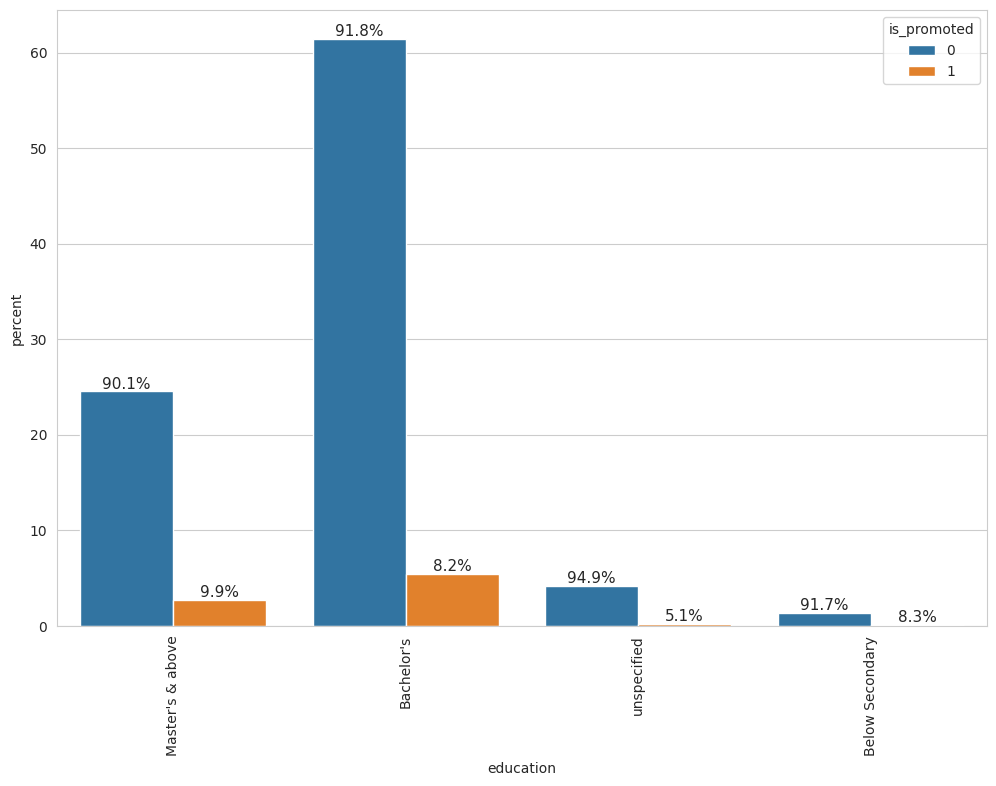

In [91]:
plt.figure(figsize=(12, 8))
ax3 = sns.countplot(x='education', hue=target_feature[0], data=df, stat="percent")

percentage_above_bar_relative_to_xgroup(ax3)
plt.xticks(rotation = 90)
plt.show()

    yes, unspecified is important
    also, we can unite some categories like no_of_trainings > 7, but it's no necessary

# Balanced train-val-test split and fit with F1 with weights on Loss

In [111]:

X_trainval, X_test, y_trainval, y_test = train_test_split(df[categorical_final_features + numerical__final_features],
                                                            df[target_feature[0]],
                                                            test_size=0.2,
                                                            random_state=42,
                                                            stratify=df[target_feature[0]]
                                                          )

X_train, X_val, y_train, y_val = train_test_split(X_trainval,
                                                  y_trainval,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  stratify=y_trainval #!
                                                  )

    Let's use balanced F1 to take into account Precision and Recall and disbalance in classes.
    Also we made a stratified split
    also use classweights

In [112]:
from catboost import CatBoostClassifier, Pool

In [113]:
from sklearn.utils import class_weight
cw = list(class_weight.compute_class_weight('balanced',
                                             classes=np.unique(y_train),
                                             y=y_train))

In [126]:
model = CatBoostClassifier(class_weights=cw,
                           use_best_model=True,
                           eval_metric='F1',
                           verbose=10,
                           custom_metric= ['F1',
                                            'Precision',
                                            'Recall',
                                            'Accuracy',
                                            'BalancedAccuracy'],
                          )

# Create a Pool object for the training and testing data
train_pool = Pool(X_train, label=y_train, cat_features=categorical_final_features)
val_pool = Pool(X_val, label=y_val, cat_features=categorical_final_features)
test_pool = Pool(X_test, label=y_test, cat_features=categorical_final_features)
# Train the model
model.fit(train_pool, eval_set=val_pool, plot=True)



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.0763
0:	learn: 0.7953337	test: 0.8048455	best: 0.8048455 (0)	total: 90.9ms	remaining: 1m 30s
10:	learn: 0.8230551	test: 0.8312406	best: 0.8335486 (8)	total: 1.22s	remaining: 1m 49s
20:	learn: 0.8275255	test: 0.8366751	best: 0.8371269 (18)	total: 1.65s	remaining: 1m 16s
30:	learn: 0.8360704	test: 0.8397207	best: 0.8411218 (29)	total: 2.17s	remaining: 1m 7s
40:	learn: 0.8370895	test: 0.8398194	best: 0.8411218 (29)	total: 2.61s	remaining: 1m
50:	learn: 0.8396554	test: 0.8417826	best: 0.8417826 (50)	total: 3.09s	remaining: 57.6s
60:	learn: 0.8404013	test: 0.8429786	best: 0.8429786 (60)	total: 3.53s	remaining: 54.4s
70:	learn: 0.8414333	test: 0.8434856	best: 0.8438085 (65)	total: 3.94s	remaining: 51.5s
80:	learn: 0.8428842	test: 0.8431065	best: 0.8438085 (65)	total: 4.34s	remaining: 49.2s
90:	learn: 0.8431724	test: 0.8433039	best: 0.8438085 (65)	total: 4.74s	remaining: 47.3s
100:	learn: 0.8436566	test: 0.8435019	best: 0.8438085 (65)	total: 5.21s	remaining: 46.4s
110:	

In [130]:
w = catboost.MetricVisualizer('/content/catboost_info')
w.start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [133]:
# Evaluate the model using CatBoost's log loss and F1 score
metrics = model.eval_metrics(test_pool,
                             metrics=['F1', 'Precision', 'Recall', 'Accuracy', 'BalancedAccuracy'],
                             plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

# Result

In [136]:
pd.DataFrame(metrics).iloc[-1] #all trees prediction on test

F1                  0.834335
Precision           0.759820
Recall              0.925054
Accuracy            0.816268
BalancedAccuracy    0.816236
Name: 146, dtype: float64

    F1                  0.834335
    Precision           0.759820
    Recall              0.925054
    Accuracy            0.816268
    BalancedAccuracy    0.816236
    Name: 146, dtype: float64